In [4]:
import snntorch as snn
import sys
import platform
import torch
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import math

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.2.1-arm64-arm-64bit
PyTorch Version: 2.0.0.dev20230210

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [105]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true">

3 main types of neuron models:
1. **Hodgkin-Huxley Neuron Models:**
    - While biophysical models can reproduce electrophysiological results with a high degree of accuracy, their complexity makes them difficult to use at present.
2. **Artificial Neuron Model:**
    - inputs are multiplied by their corresponding weights and passed through an activation function
    - This simplification has enabled deep learning researchers to perform incredible feats in computer vision, natural language processing, and many other machine learning-domain tasks
3. **Leaky Integrate-and-Fire Neuron Models:**
    - Takes sum of weighted inputs similar to artificial neurons, but instead of directly passing through an activation function, the weighted sum is integrated over time with leakage, similar to an RC circuit
    - neurons emit a voltage spike when the integrated value exceeds a threshold
    - LIF neurons abstract way the shape and profile of the output spike; it is simply treated as a discrete event. 
    - information is not stored within the spike, but rather the frequency of spikes
    - LIF neuron sits in between biological plausibility of Hodgkin-Huxley models and the practicality of artificial neurons

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_2_intuition.png?raw=true">

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_RCmembrane.png?raw=true">

The derived analytical solution to the LIF neuron is not directly useful in a neural network training setting. Euler's method can be used to solve the linear ODE, which returns discrete, recurrent representation of the LIF neuron. 

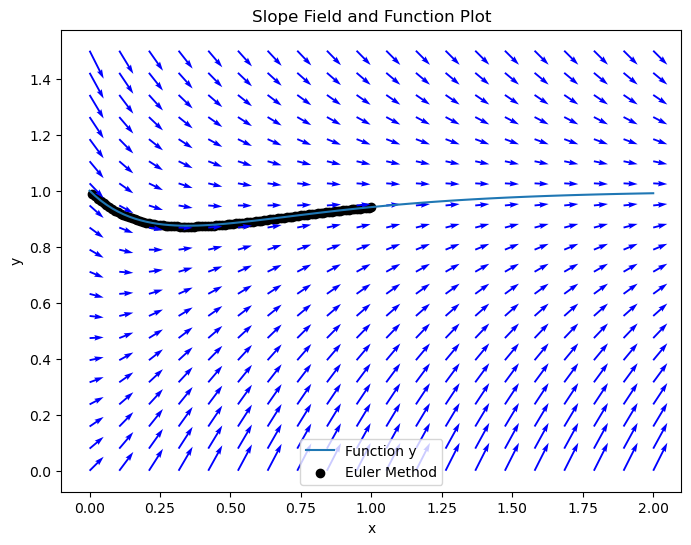

In [9]:
def eulers_method(dx, x0, y0, h, n):
  solutions = []
  for i in range(n):
    m = dx(x0, y0)
    y1 = y0 + m*h
    x1 = x0 + h
    solutions.append([m, x1, y1])
    y0 = y1 
    x0 = x1 
  return solutions 

# Define function
def f(x):
    return 1 + 0.5*np.exp(-4*x) - 0.5*np.exp(-2*x)

# define differential 
def dydx(x, y):
  return 2-np.exp(-4*x)-2*y

def gen_plot(f, dydx, solutions):
  # Create a list of x values
  x = np.linspace(0, 2, 100)

  # Evaluate the function on the list of x values
  y = f(x)

  # Create a plot
  fig, ax = plt.subplots(figsize=(8,6))
  ax.plot(x, y, label='Function y')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('Slope Field and Function Plot')
  ax.legend()

  # Extract x and y values from the list of points
  x_vals = [p[1] for p in solutions]
  y_vals = [p[2] for p in solutions]

  # Plot the points using the scatter() function
  ax.scatter(x_vals, y_vals, color='black', label='Euler Method')

  # Add a legend
  ax.legend()

  # Create a grid of x and y values for the slope field
  X, Y = np.meshgrid(np.linspace(0, 2, 20), np.linspace(0, 1.5, 20))

  # Compute the slope field
  U = np.ones_like(X)
  V = dydx(X, Y)

  # Add the slope field to the plot
  ax.quiver(X, Y, U, V, color='blue', angles='xy', scale_units='xy', scale=20)

  # Show the plot
  plt.show()

solutions = eulers_method(dydx, 0, 1, 0.01, 100)
gen_plot(f, dydx, solutions)


    

In [11]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
    tau = R*C
    U = U + (time_step/tau)*(-U + I*R)
    return U 

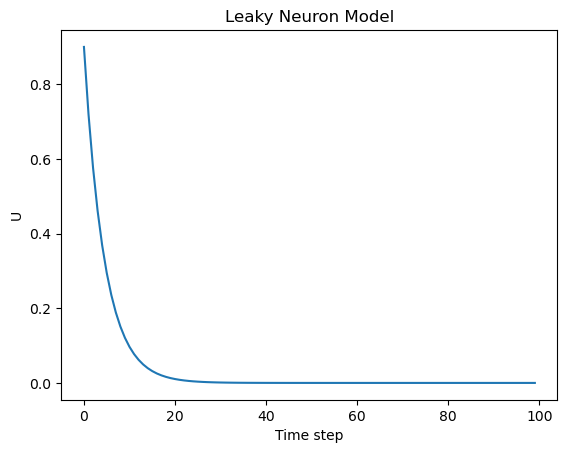

In [12]:
num_steps = 100
U = 0.9
U_trace = []  # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U)  # solve next step of U

def plot_mem(U_trace, title):
    plt.plot(U_trace)
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("U")
    plt.show()

plot_mem(U_trace, "Leaky Neuron Model")


# Lapicque's LIF Neuron 



In [24]:
time_step = 1e-3
R = 5
C = 1e-3

# leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

**Inputs of Lapicque**
- `spk_in`: each element $I_{in}$ is sequentially passed as an input
- `mem`: membrane potential, previously $U[t]$, also passed as input. $U[0] = 0.9V$ 

**Outputs of Lapicque**
- `spk_out`: output spike $S_{out}[t+\triangle t]$ at next time step (1 if spike; 0 if no spike)
- `mem`: membrane potential $U_{mem}[t+\triangle t]$ at next time step 

In [25]:
# Initialie membrane, input, and output 
mem = torch.ones(1) * 0.9 # U=0.9 at t=0
cur_in = torch.zeros(num_steps) # I=0 for all t 
spk_out = torch.zeros(1) # initialize output spikes 

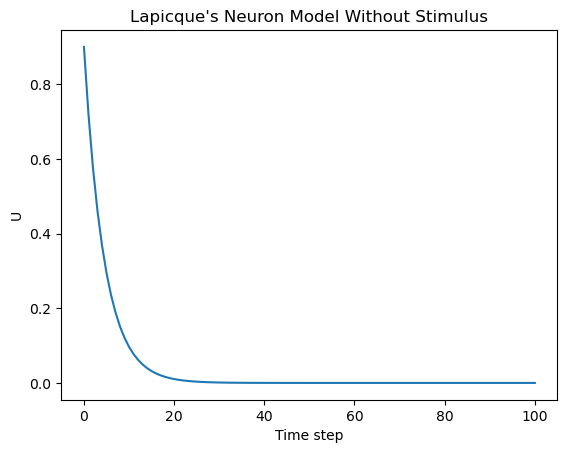

In [26]:
# store membrane potentials over time 
mem_rec = [mem]

# pass updated value of mem and cur_in[step]=0 at every time step
for step in range(num_steps):
    spk_out, mem = lif1(cur_in[step], mem)
    # print(spk_out)

    # Store recordings of membrane potential 
    mem_rec.append(mem)

# convert the list of tensors into one tensor 
mem_rec = torch.stack(mem_rec)

# pre-defined plotting function 
plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

# Lapicque: Step Input 

Given the general solution:

$$U_{mem} = I_{in}(t)R + [U_0-I_{in}(t)R]e^{-t/\tau}$$

If the membrane potential is initialized to $U_{mem}(t=0) = 0V$, then: 

$$U_{mem} = I_{in}(t)R[1-e^{-t/\tau}]$$

Based on this explicit time-dependent form, we expect $U_{mem}$ to relax exponentially towards $I_{in}R$.

In [27]:
# Initialize input current pulse
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.1), 0)  # input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1)  # membrane potential of 0 at t=0
spk_out = torch.zeros(1)  # neuron needs somewhere to sequentially dump its output spikes
mem_rec = [mem]

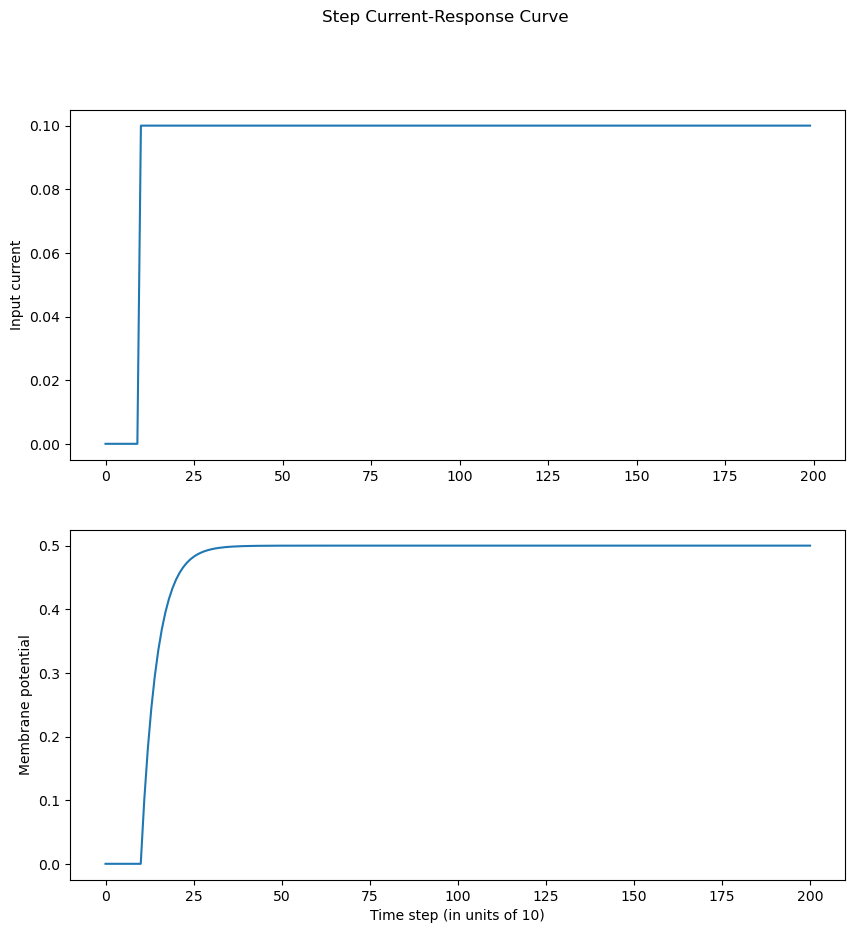

In [28]:
num_steps = 200

# pass updated value of mem and cur_in[step] at every time step
for step in range(num_steps):
  spk_out, mem = lif1(cur_in[step], mem)
  mem_rec.append(mem)

# crunch -list- of tensors into one tensor
mem_rec = torch.stack(mem_rec)

def plot_step_current_response(cur_in, mem_rec, step_size):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle('Step Current-Response Curve')
    axs[0].plot(cur_in)
    axs[0].set_ylabel('Input current')
    axs[1].plot(mem_rec)
    axs[1].set_xlabel('Time step (in units of {})'.format(step_size))
    axs[1].set_ylabel('Membrane potential')
    plt.show()


plot_step_current_response(cur_in, mem_rec, 10)

In [29]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")


The calculated value of input pulse [A] x resistance [Ω] is: 0.5 V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


# Lapicque: Pulse Input

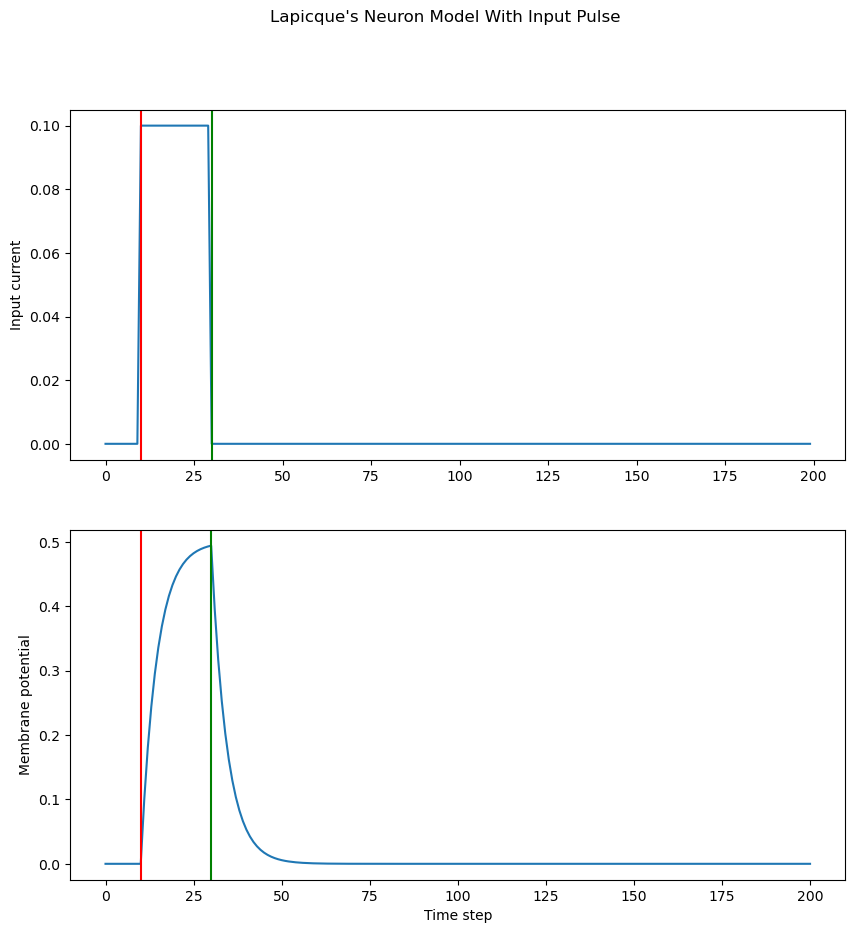

In [33]:
# Initialize current pulse, membrane and outputs
cur_in1 = torch.cat((torch.zeros(10), torch.ones(20)*(0.1), torch.zeros(170)), 0)  # input turns on at t=10, off at t=30
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]

def plot_current_pulse_response(cur_in, mem_rec, title, vline1=None, vline2=None):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(title)
    axs[0].plot(cur_in)
    axs[0].set_ylabel('Input current')
    axs[1].plot(mem_rec)
    axs[1].set_xlabel('Time step')
    axs[1].set_ylabel('Membrane potential')
    if vline1 is not None:
        axs[0].axvline(vline1, color='r')
        axs[1].axvline(vline1, color='r')
    if vline2 is not None:
        axs[0].axvline(vline2, color='g')
        axs[1].axvline(vline2, color='g')
    plt.show()


# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in1[step], mem)
  mem_rec1.append(mem)
mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)


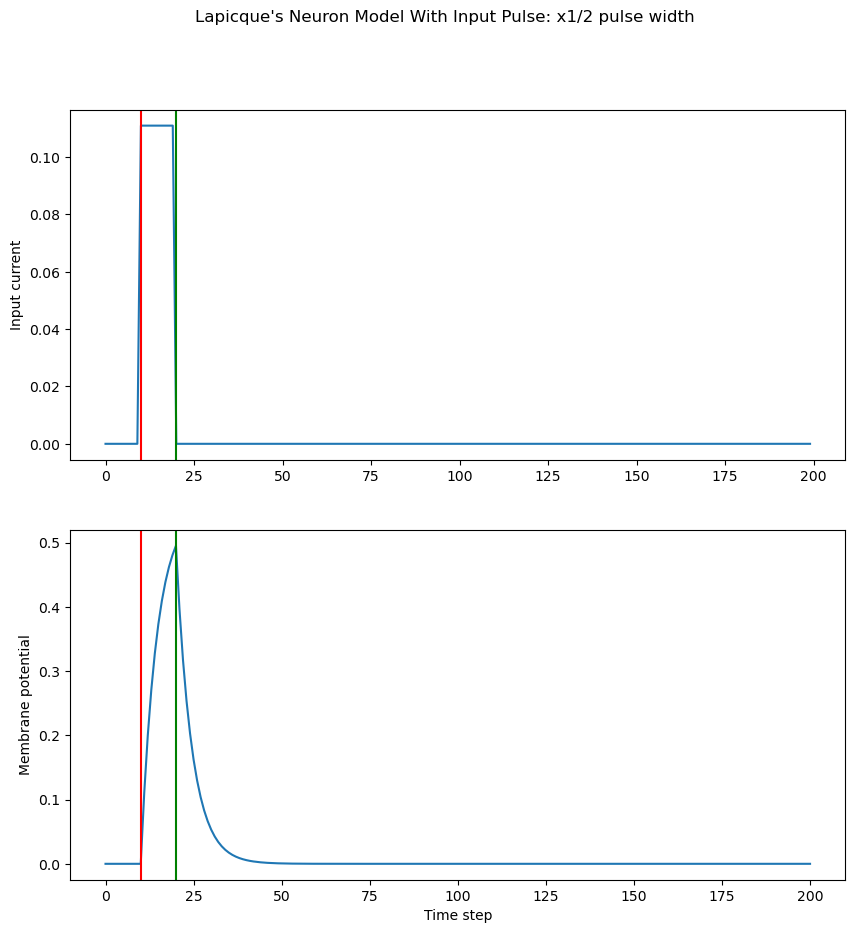

In [34]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10), torch.ones(10)*0.111, torch.zeros(180)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)


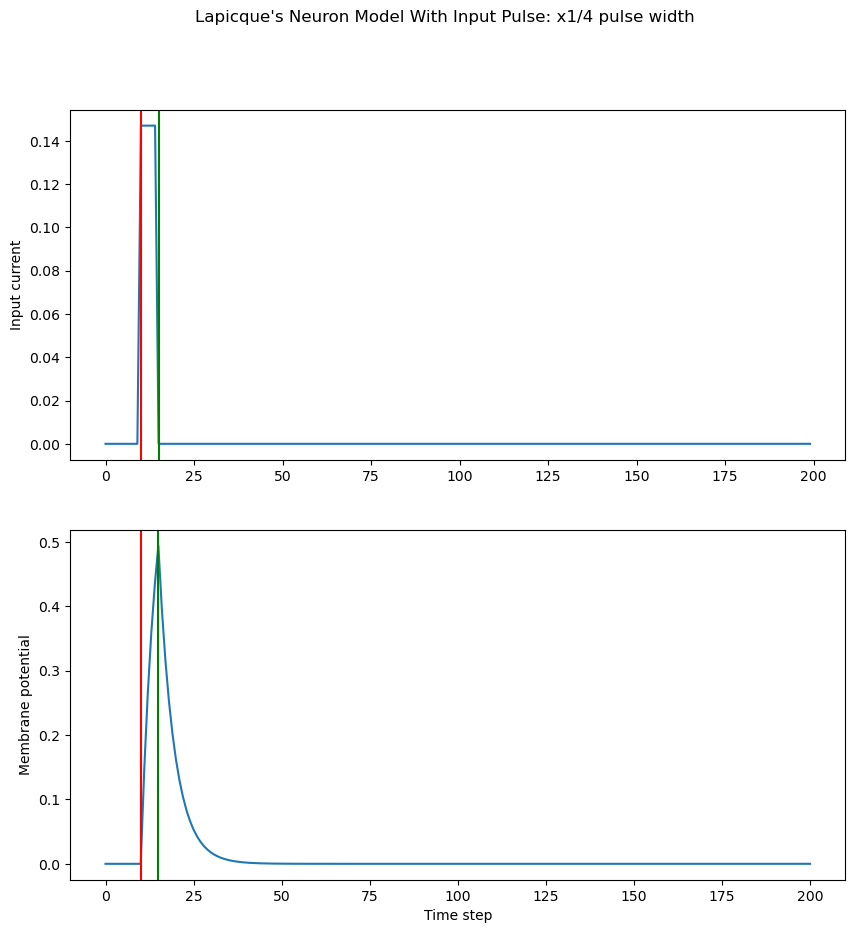

In [35]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10), torch.ones(5)*0.147, torch.zeros(185)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

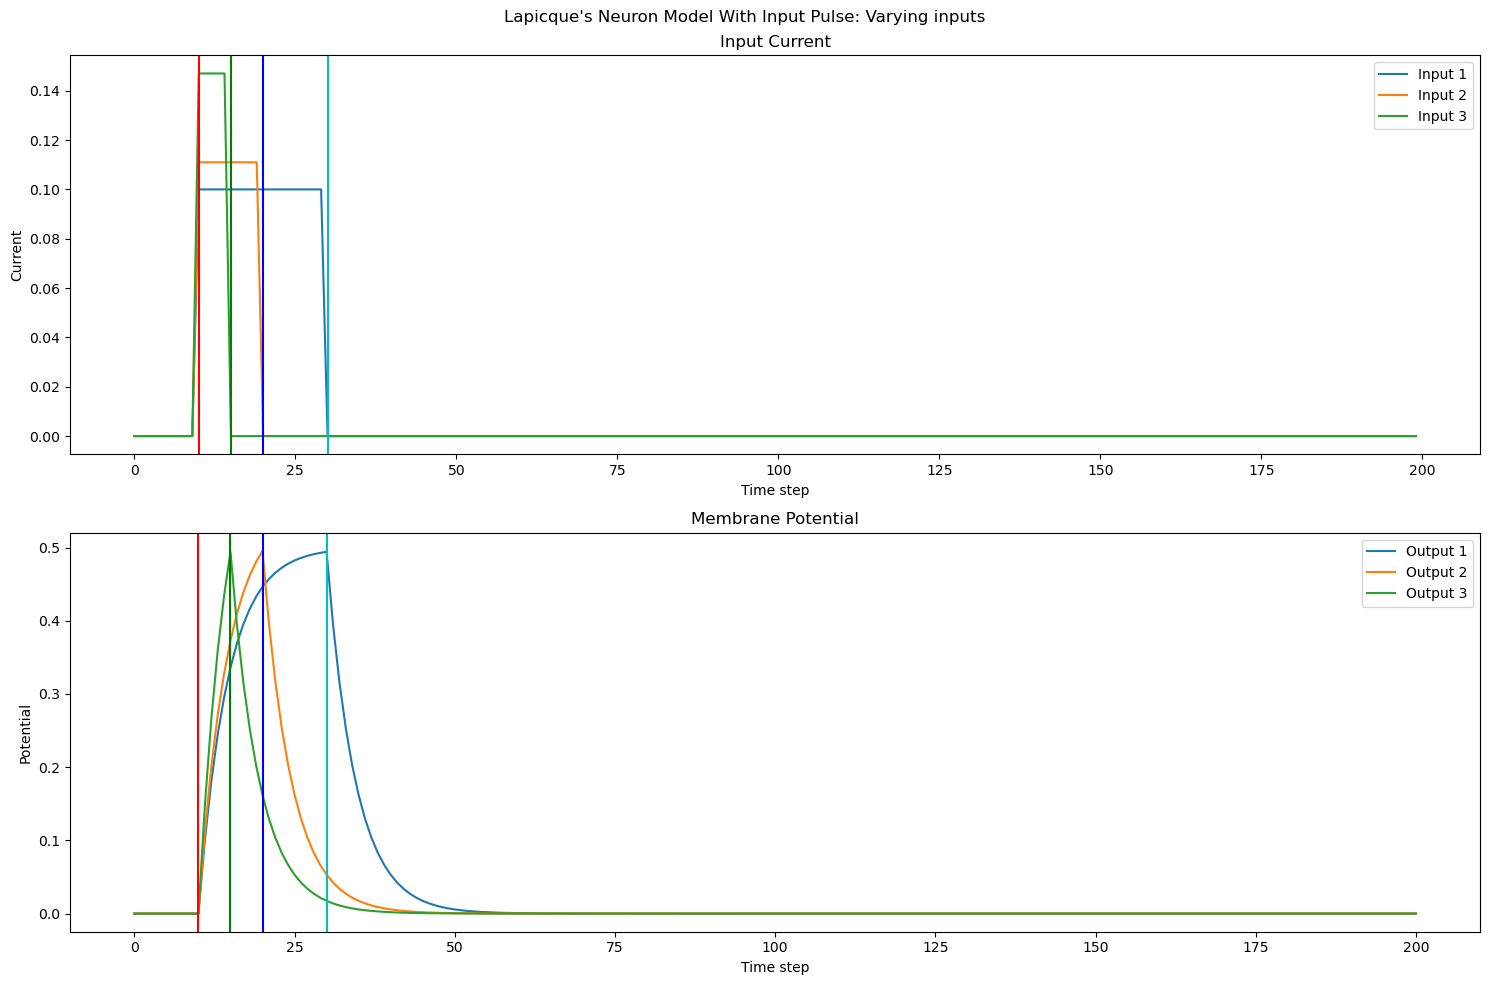

In [42]:
def compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, vline1, vline2, vline3, vline4, title):
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(title)
    axs[0].plot(cur_in1, label='Input 1')
    axs[0].plot(cur_in2, label='Input 2')
    axs[0].plot(cur_in3, label='Input 3')
    axs[0].set_title('Input Current')
    axs[0].set_xlabel('Time step')
    axs[0].set_ylabel('Current')
    axs[0].legend()
    axs[0].axvline(vline1, color='r')
    axs[0].axvline(vline2, color='g')
    axs[0].axvline(vline3, color='b')
    axs[0].axvline(vline4, color='c')
    axs[1].plot(mem_rec1, label='Output 1')
    axs[1].plot(mem_rec2, label='Output 2')
    axs[1].plot(mem_rec3, label='Output 3')
    axs[1].set_title('Membrane Potential')
    axs[1].set_xlabel('Time step')
    axs[1].set_ylabel('Potential')
    axs[1].legend()
    axs[1].axvline(vline1, color='r')
    axs[1].axvline(vline2, color='g')
    axs[1].axvline(vline3, color='b')
    axs[1].axvline(vline4, color='c')
    plt.tight_layout()
    plt.show()

compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

As the input current pulse amplitude increases, the rise time of the membrane potential speeds up. In the limit of the input current pulse width becoming infinitesimally small, $T_{W} \rightarrow 0s$, the membrane potential will jump straight up in virtually zero rise time:

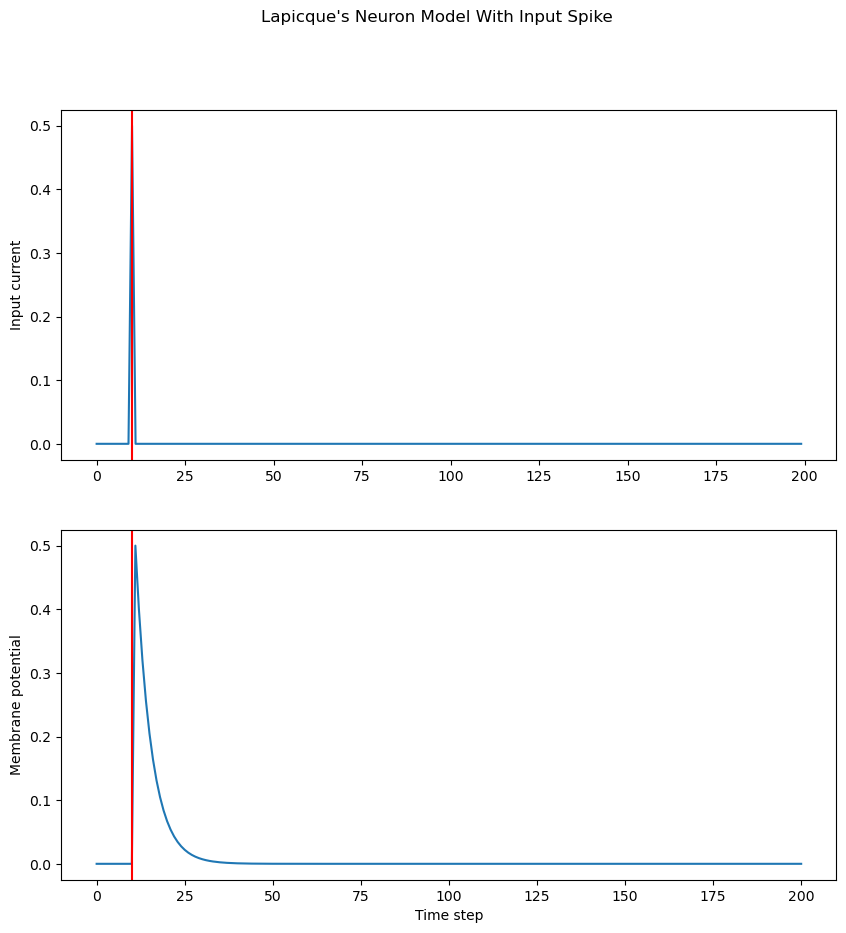

In [44]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10), torch.ones(1)*0.5, torch.zeros(189)), 0)  # input only on for 1 time step
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike",
                            vline1=10)

Current pulse width can now be interpreted as a spike; charge is delivered in an infinitely short period of time, $I_{in} = Q/t_0$ where $t_0 \rightarrow 0$. More formally: 

$$I_{in} = Q\delta(t-t_0)$$

where $\delta(t)$ is the Dirac-Delta function. Basic idea here is $I_{in} = Q$ when $t = t_0$ and $I_{in} = 0$ everywhere else. The Dirac-Delta function kinda acts as a filter in time, damping the value until a certain time point. 

# Lapicque: Firing

For a neuron to generate and emit its own spikes at the output, the passive membrane model must be combined with a threshold. 

When the membrane potential exceeds the threshold, a voltage spike will generated, external to the passive membrane model. 

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_4_spiking.png?raw=true">

In [83]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

Set `threshold=1`, and apply a step current to get this neuron spiking. 

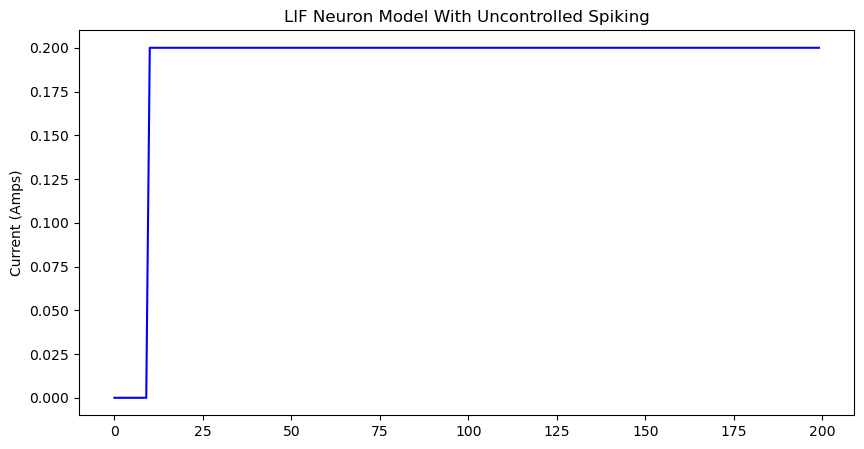

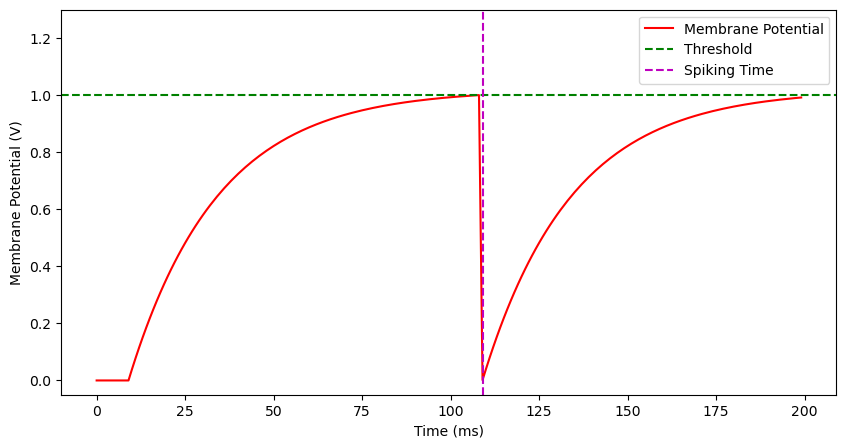

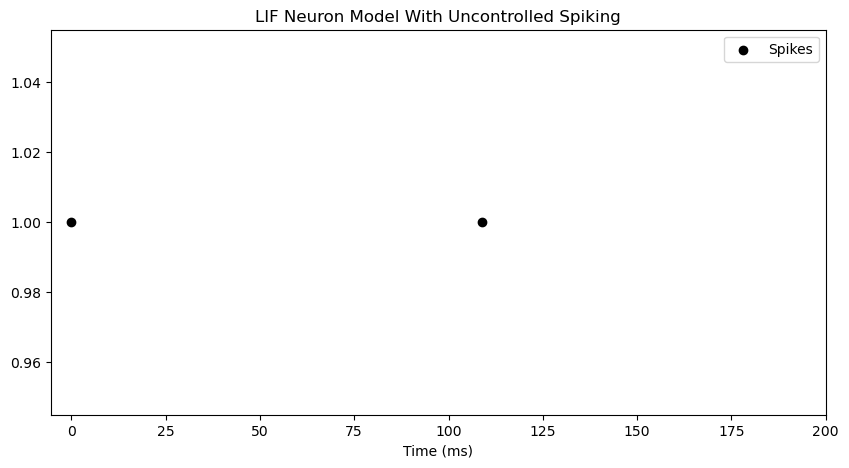

In [101]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

import matplotlib.pyplot as plt
import torch

import matplotlib.pyplot as plt
import torch

def plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line, ylim_max2, title, vline=None):
    # plot current input
    fig1, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(cur_in, 'b')
    ax1.set_ylabel('Current (Amps)')
    ax1.set_title(title)

    # plot membrane potential
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(mem_rec, 'r', label='Membrane Potential')
    ax2.axhline(y=thr_line, color='g', linestyle='--', label='Threshold')
    if vline:
       ax2.axvline(x=vline, color='m', linestyle='--', label='Spiking Time')
    ax2.set_ylabel('Membrane Potential (V)')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylim(top=ylim_max2)
    ax2.legend()

    # plot spikes
    fig3, ax3 = plt.subplots(figsize=(10, 5))
    spike_indices = torch.nonzero(spk_rec)
    # zero_indices = torch.nonzero(spk_rec == 0)
    # response_idx = torch.cat((spike_indices, zero_indices))
    # response = torch.cat((torch.ones_like(spike_indices), torch.zeros_like(zero_indices)))
    ax3.scatter(spike_indices, torch.ones_like(spike_indices), marker='o', color='black', label='Spikes')
    ax3.set_xlabel('Time (ms)')
    ax3.set_title(title)
    ax3.set_xlim(right=len(cur_in))
    ax3.legend()

    plt.show()

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="LIF Neuron Model With Uncontrolled Spiking", vline=109)

The output spike should reset, membrane potential should hyperpolarize back to irs resting potential after firing. 

In [90]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
    tau_mem = R*C
    spk = (mem > threshold)
    mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold # every time spk=1, subtract the threshold
    return mem, spk

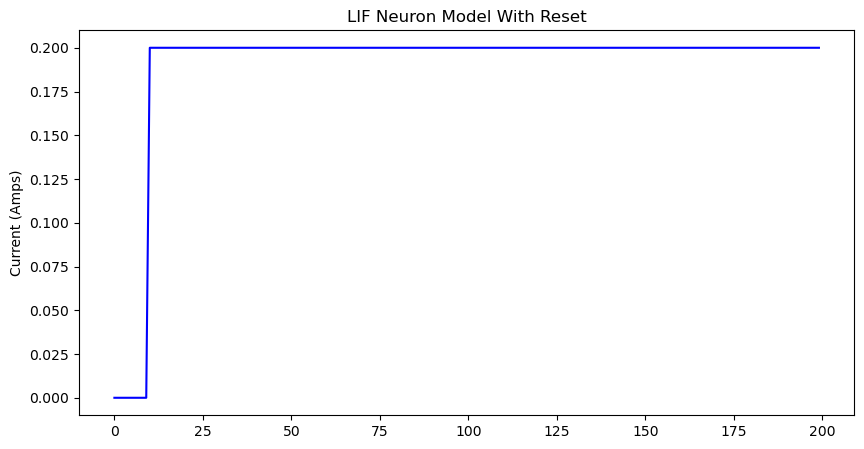

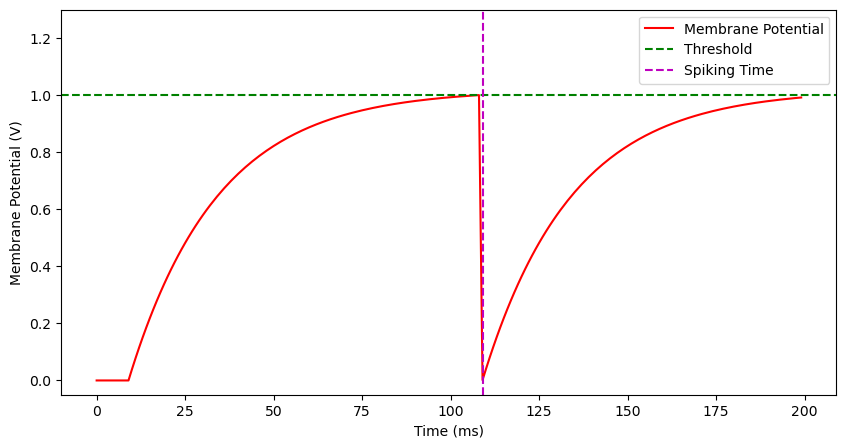

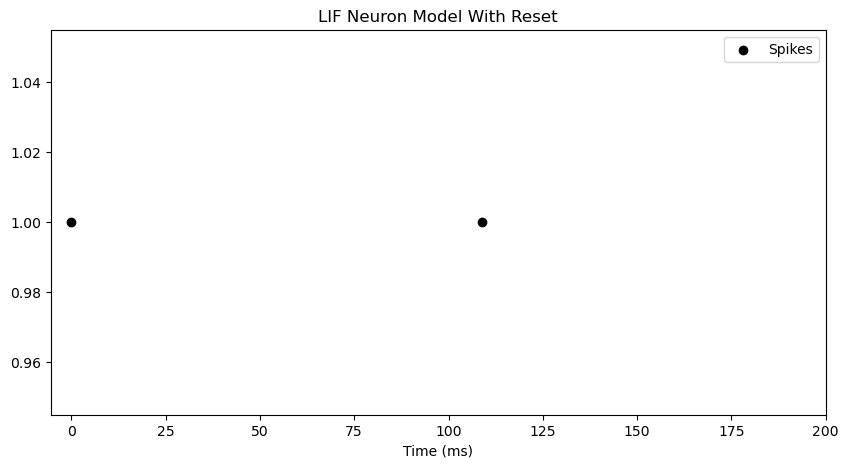

In [91]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset", vline=109)

In [92]:
# Create the same neuron as before using snnTorch
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


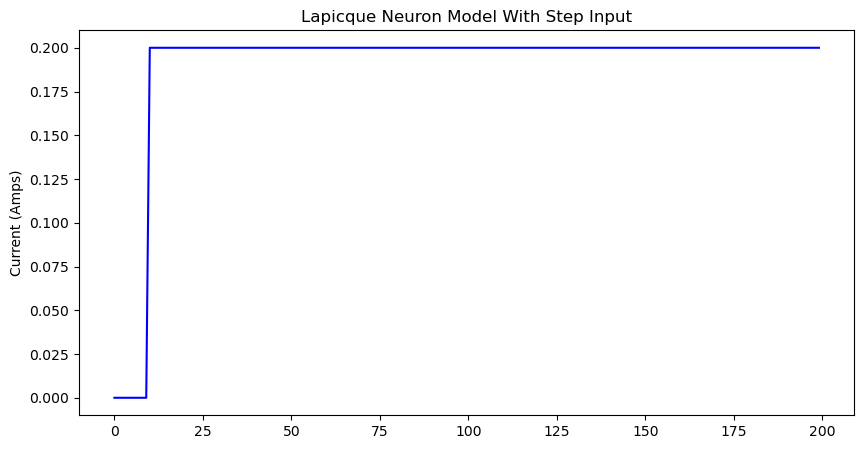

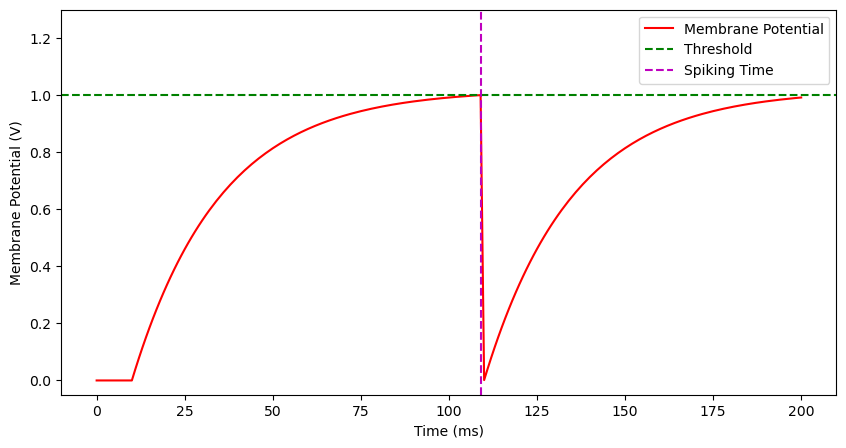

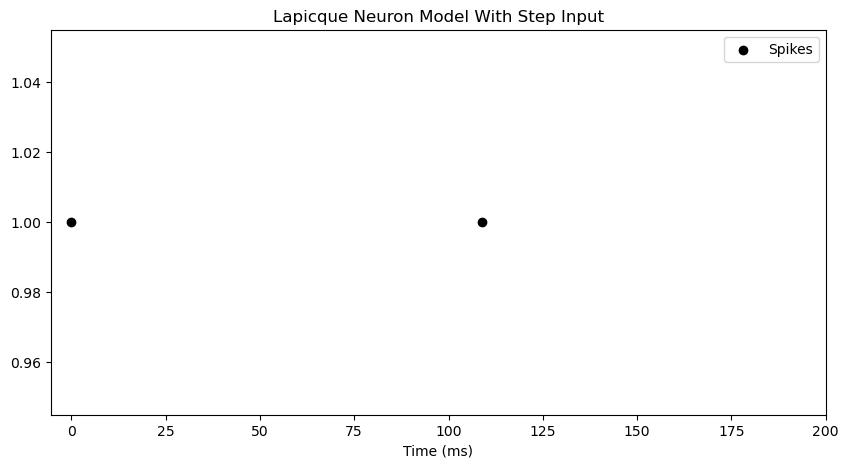

In [93]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 100 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Step Input", vline=109)

Spike occurs roughly between $t \epsilon (105, 115)$ and the membrane potential is also reset within that interval. 

In [94]:
print(spk_rec[105:115].view(-1))

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


Absence of a spike is represented by S_{out} = 0, occurence of a spike is S_{out} = 1.

If $I_{in}$ increases, the membrane potential approaches the threshold $U_{thr}$ faster.

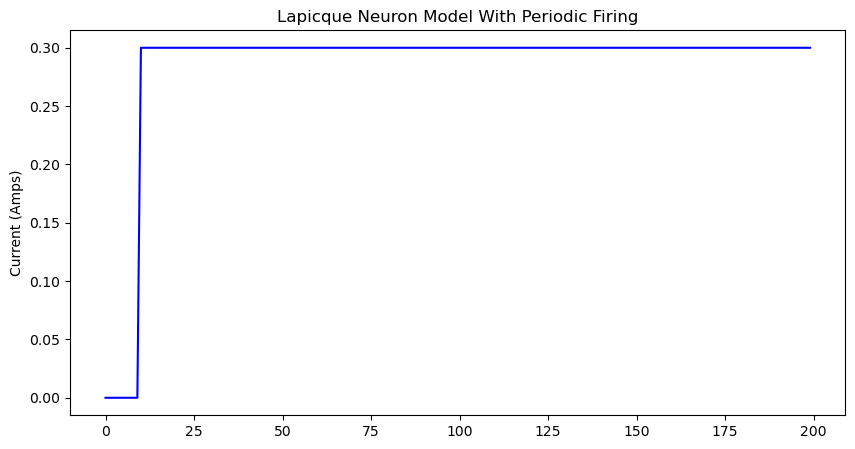

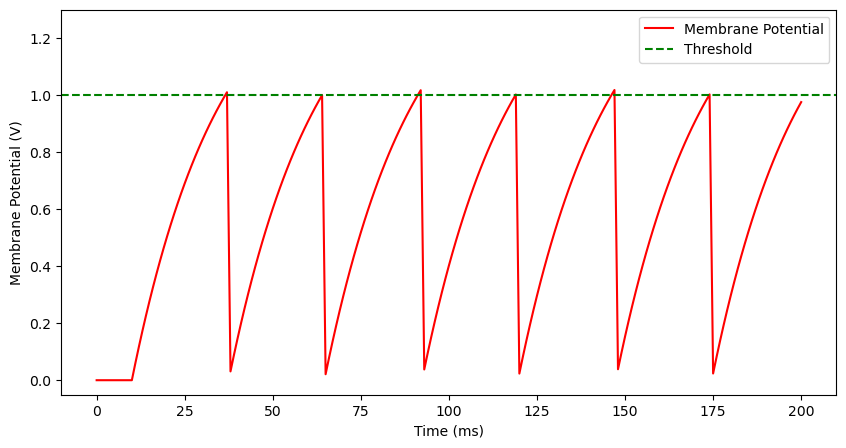

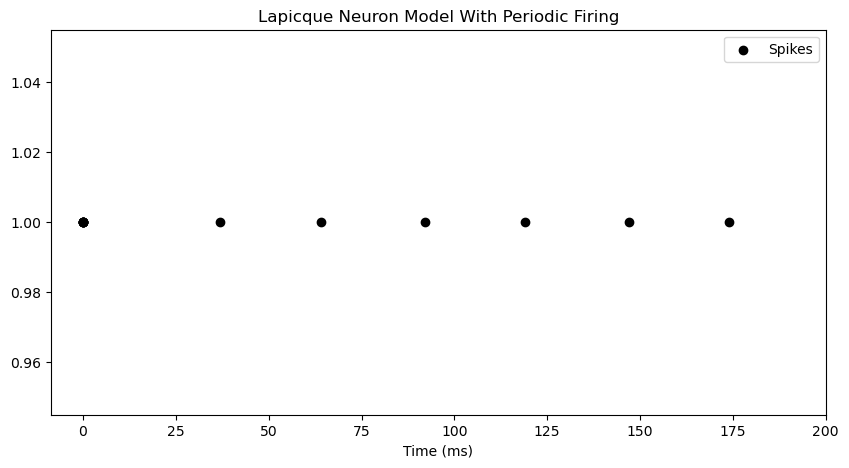

In [102]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")

A similar increase in firing frequency can also be induced by decreasing the threshold. 

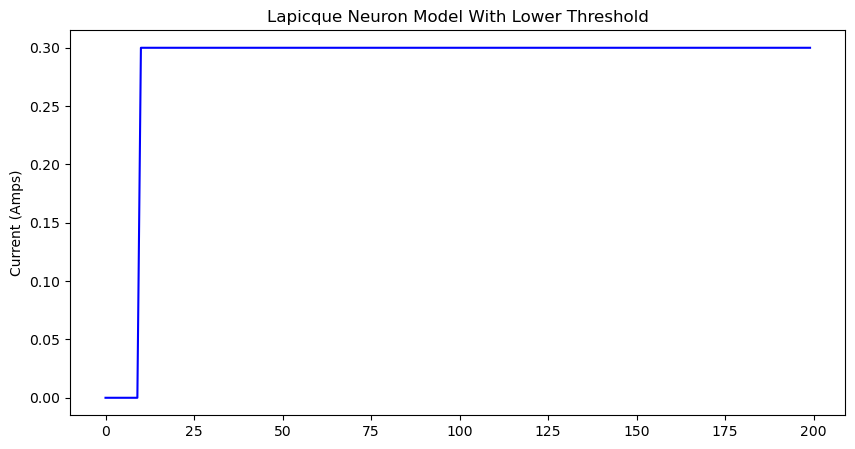

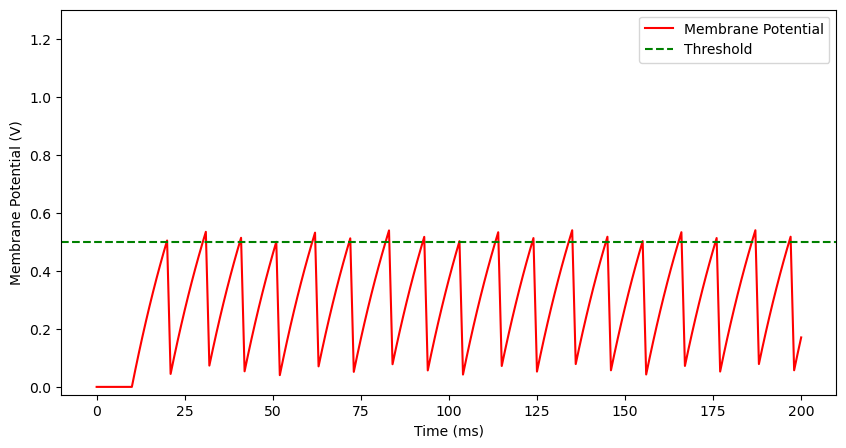

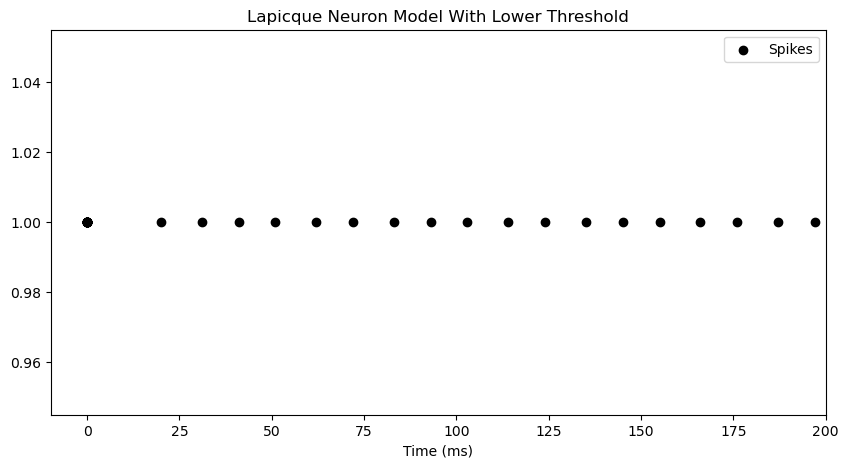

In [103]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.3), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Lower Threshold")

# Lapicque: Spike Inputs 

In [122]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

There are 73 total spikes out of 200 time steps.


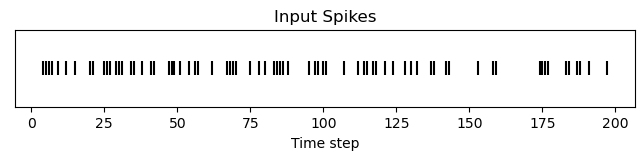

In [123]:
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

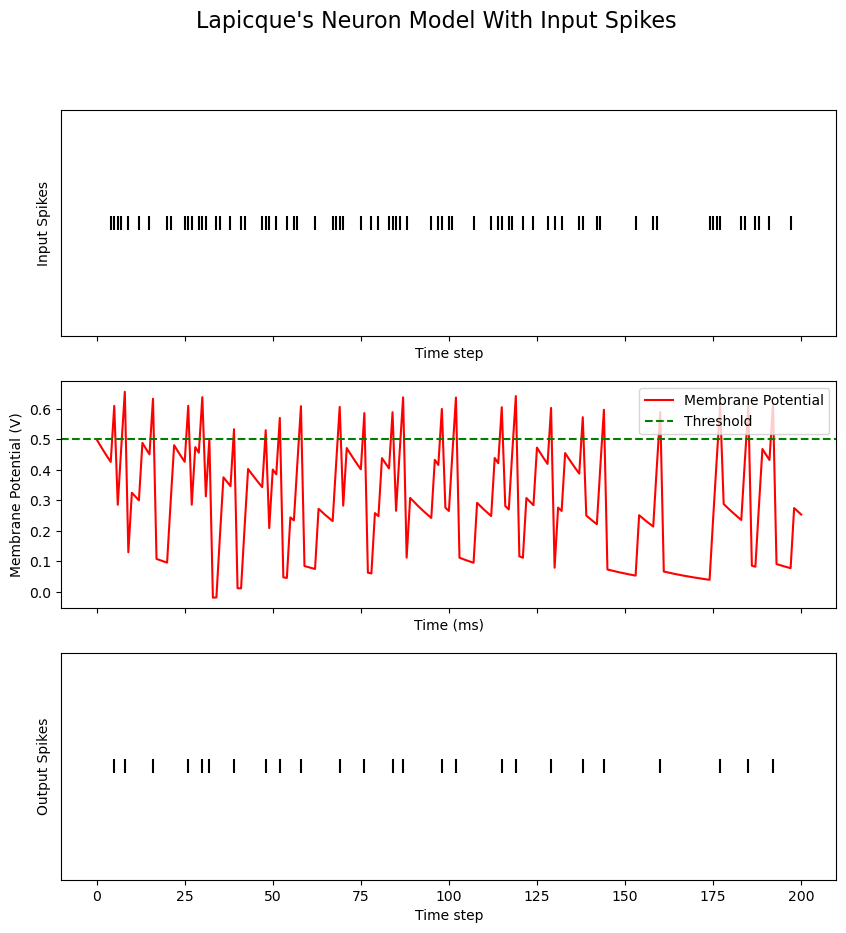

In [138]:
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron stim
for step in range(num_steps):
    spk_out, mem = lif3(spk_in[step], mem)
    spk_rec.append(spk_out)
    mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

import matplotlib.pyplot as plt

def plot_spk_mem_spk(spk_in, mem_rec, spk_out, title="", thr_line = 0.5, vline=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True) 
    fig.suptitle(title, fontsize=16)
     # plot input spikes
    # fig1, ax1 = plt.subplots(figsize=(10, 5))
    
    splt.raster(spk_in.reshape(num_steps, -1), ax1, s=100, c="black", marker="|")
    ax1.set_ylabel("Input Spikes")
    ax1.set_xlabel("Time step")
    ax1.set_yticks([])
    # ax1.yticks([])

    # plot membrane potential
    # fig2, ax2 = plt.subplots(figsize=(10, 5))
    ax2.plot(mem_rec, 'r', label='Membrane Potential')
    ax2.axhline(y=thr_line, color='g', linestyle='--', label='Threshold')
    if vline:
       ax2.axvline(x=vline, color='m', linestyle='--', label='Spiking Time')
    ax2.set_ylabel('Membrane Potential (V)')
    ax2.set_xlabel('Time (ms)')
    # ax2.set_ylim(top=ylim_max2)
    ax2.legend()

    # plot output spikes
    # fig3, ax3 = plt.subplots(facecolor="w", figsize=(10, 5))

    splt.raster(spk_out, ax3, s=100, c="black", marker="|")
    ax3.set_ylabel("Output Spikes")
    ax3.set_xlabel("Time step")
    ax3.set_yticks([])

    plt.show()


plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Lapicque's Neuron Model With Input Spikes")


# Lapicque: Reset Mechanisms

There are two ways to implement the reset mechanism:

1. *reset by subtraction* (default) - subtract the threshold from the membrane potential each time a spike is generated;
2. *reset to zero* - force the membrane potential to zero each time a spike is generated.
3. *no reset* - do nothing, and let the firing go potentially uncontrolled.

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_5_reset.png?raw=true" width="500">



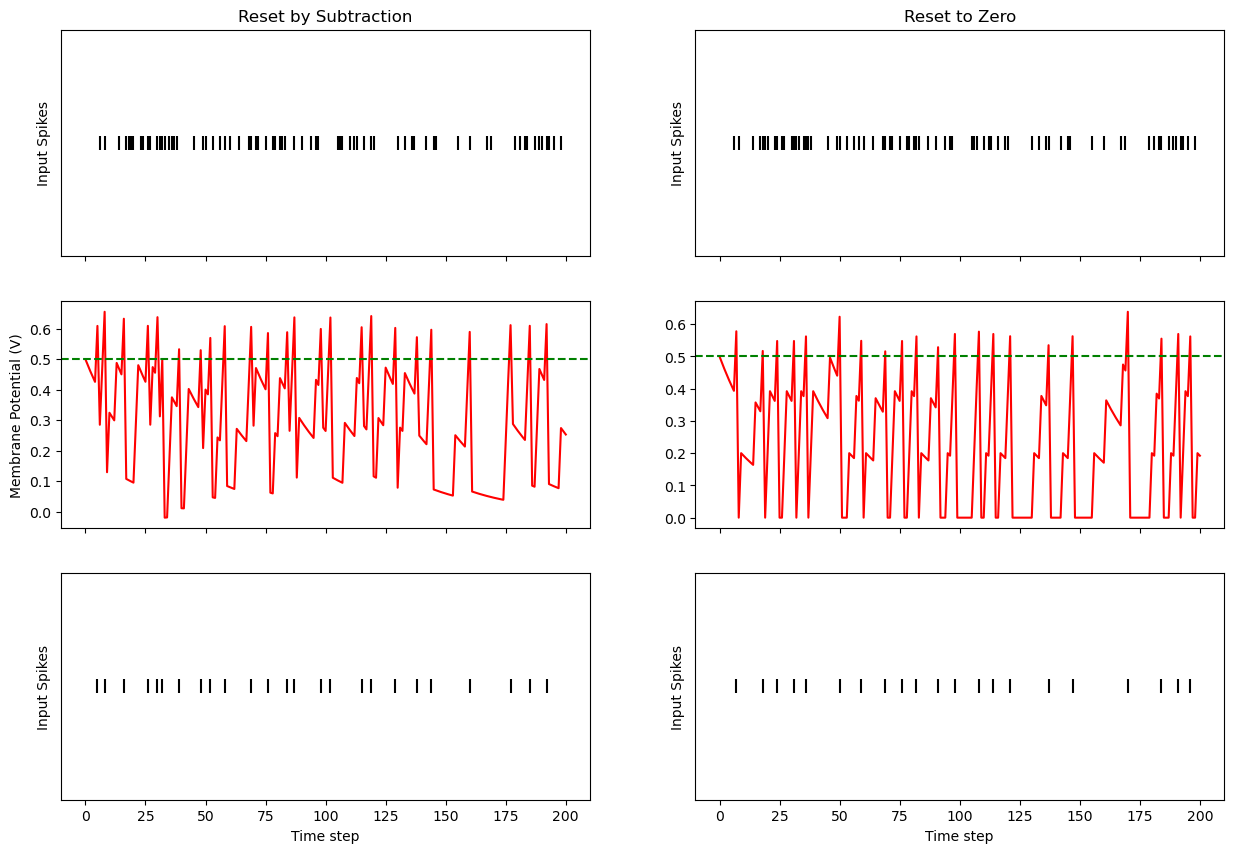

In [153]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

def plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0, thr_line=0.5):
  fig, axs = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

  splt.raster(spk_in.reshape(num_steps, -1), axs[0, 0], s=100, c="black", marker="|")
  axs[0, 0].set_ylabel("Input Spikes")
  axs[0, 0].set_title("Reset by Subtraction")
  axs[0, 0].set_yticks([])

  splt.raster(spk_in.reshape(num_steps, -1), axs[0, 1], s=100, c="black", marker="|")
  axs[0, 1].set_ylabel("Input Spikes")
  axs[0, 1].set_title("Reset to Zero")
  axs[0, 1].set_yticks([])

  # plot membrane potential
  # fig2, ax2 = plt.subplots(figsize=(10, 5))
  axs[1, 0].plot(mem_rec, 'r', label='Membrane Potential')
  axs[1, 0].axhline(y=thr_line, color='g', linestyle='--', label='Threshold')
  axs[1, 0].set_ylabel('Membrane Potential (V)')
  # axs[1, 0].set_xlabel('Time (ms)')

  axs[1, 1].plot(mem_rec0, 'r', label='Membrane Potential')
  axs[1, 1].axhline(y=thr_line, color='g', linestyle='--', label='Threshold')
  # axs[1, 1].set_ylabel('Membrane Potential (V)')

  splt.raster(spk_rec, axs[2, 0], s=100, c="black", marker="|")
  axs[2, 0].set_ylabel("Input Spikes")
  axs[2, 0].set_xlabel("Time step")
  axs[2, 0].set_yticks([])

  splt.raster(spk_rec0, axs[2, 1], s=100, c="black", marker="|")
  axs[2, 1].set_ylabel("Input Spikes")
  axs[2, 1].set_xlabel("Time step")
  axs[2, 1].set_yticks([])

  
  plt.show()

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)

Applying `"subtract"` is less lossy, because it does not ignore how much the membrane exceeds the threshold by. 

On the other hand, applying `"zero"` promotes sparsity and ***potentially less power consumption*** when running on dedicated neuromorphic hardware. 